# Installs & Imports

In [1]:
!pip install -q pmdarima cvxpy mystic torch-optimizer

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pandas_datareader import data as pdr
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

from scipy.optimize import minimize, Bounds, LinearConstraint
import cvxpy as cp
from mystic.solvers import fmin
from mystic.constraints import as_constraint

import torch_optimizer as torch_optim

# Set plot styles
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
plt.rcParams['figure.figsize'] = (14, 8)

# Load the Data

In [3]:
def load_steel_price_data(start_date='2010-01-01', end_date=None):
    """
    Load steel price data from the FRED API using pandas-datareader.

    Parameters:
    - start_date: Start date for data retrieval (default: '2010-01-01').
    - end_date: End date for data retrieval (default: today).

    Returns:
    - data: DataFrame containing steel price data.
    """
    if end_date is None:
        end_date = datetime.today().strftime('%Y-%m-%d')
    try:
        steel_price_data = pdr.DataReader('WPU10170501', 'fred', start_date, end_date)
        steel_price_data.rename(columns={'WPU10170501': 'Steel_Price'}, inplace=True)
        steel_price_data.index.name = 'Date'
        return steel_price_data
    except Exception as e:
        print(f"Error loading steel price data: {e}")
        return pd.DataFrame()

In [4]:
# Load steel price data
steel_data = load_steel_price_data()
display(steel_data.head(10))

# Print dataset shape
print(f"\nDataset shape: {steel_data.shape}")

,Steel_Price
Date,
2010-01-01,229.5
2010-02-01,233.9
2010-03-01,236.0
2010-04-01,242.7
2010-05-01,246.1
2010-06-01,247.0
2010-07-01,246.6
2010-08-01,244.4
2010-09-01,244.5



Dataset shape: (179, 1)


In [5]:
def load_additional_exog_data(start_date='2010-01-01', end_date=None):
    """
    Load additional exogenous variables from the FRED API.

    Parameters:
    - start_date: Start date for data retrieval (default: '2010-01-01').
    - end_date: End date for data retrieval (default: today).

    Returns:
    - exog_data: DataFrame containing exogenous variables.
    """
    if end_date is None:
        end_date = datetime.today().strftime('%Y-%m-%d')

    # Define FRED series codes for exogenous variables
    exog_series = {
        'Iron_Price': 'WPU101105',
        'Lumber_Price': 'WPU084101'
    }

    exog_data = pd.DataFrame()

    for name, code in exog_series.items():
        try:
            exog = pdr.DataReader(code, 'fred', start_date, end_date)
            exog.rename(columns={code: name}, inplace=True)
            exog_data = pd.concat([exog_data, exog], axis=1)
            exog_data.index.name = 'Date'
        except Exception as e:
            print(f"Data for {name} ({code}) not found: {e}")

    return exog_data

In [6]:
# Load additional exogenous variables
exog_data = load_additional_exog_data()
display(exog_data.head(10))

,Iron_Price,Lumber_Price
Date,,
2010-01-01,146.8,197.0
2010-02-01,146.8,197.4
2010-03-01,147.8,204.0
2010-04-01,147.9,207.6
2010-05-01,155.9,211.0
2010-06-01,156.7,213.0
2010-07-01,157.6,208.2
2010-08-01,159.1,209.0
2010-09-01,159.1,209.3


In [7]:
def merge_data(steel_data, exog_data):
    """
    Merge steel price data with exogenous variables.

    Parameters:
    - steel_data: DataFrame containing steel price data.
    - exog_data: DataFrame containing exogenous variables.

    Returns:
    - merged_data: Merged DataFrame.
    """
    merged_data = steel_data.merge(exog_data, left_index=True, right_index=True, how='left')
    merged_data.fillna(method='ffill', inplace=True)  # Forward fill to handle missing values
    return merged_data

In [8]:
# Merge data
data = merge_data(steel_data, exog_data)
display(data.head(10))
print(f"\nDataset shape: {data.shape}")

,Steel_Price,Iron_Price,Lumber_Price
Date,,,
2010-01-01,229.5,146.8,197.0
2010-02-01,233.9,146.8,197.4
2010-03-01,236.0,147.8,204.0
2010-04-01,242.7,147.9,207.6
2010-05-01,246.1,155.9,211.0
2010-06-01,247.0,156.7,213.0
2010-07-01,246.6,157.6,208.2
2010-08-01,244.4,159.1,209.0
2010-09-01,244.5,159.1,209.3



Dataset shape: (179, 3)


# Explore the Data

In [9]:
def plot_time_series(data, title, ylabel):
    """
    Plot time series data.

    Parameters:
    - data: DataFrame to plot.
    - title: Title of the plot.
    - ylabel: Y-axis label.
    """
    plt.figure(figsize=(14, 6))
    for column in data.columns:
        plt.plot(data.index, data[column], label=column)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

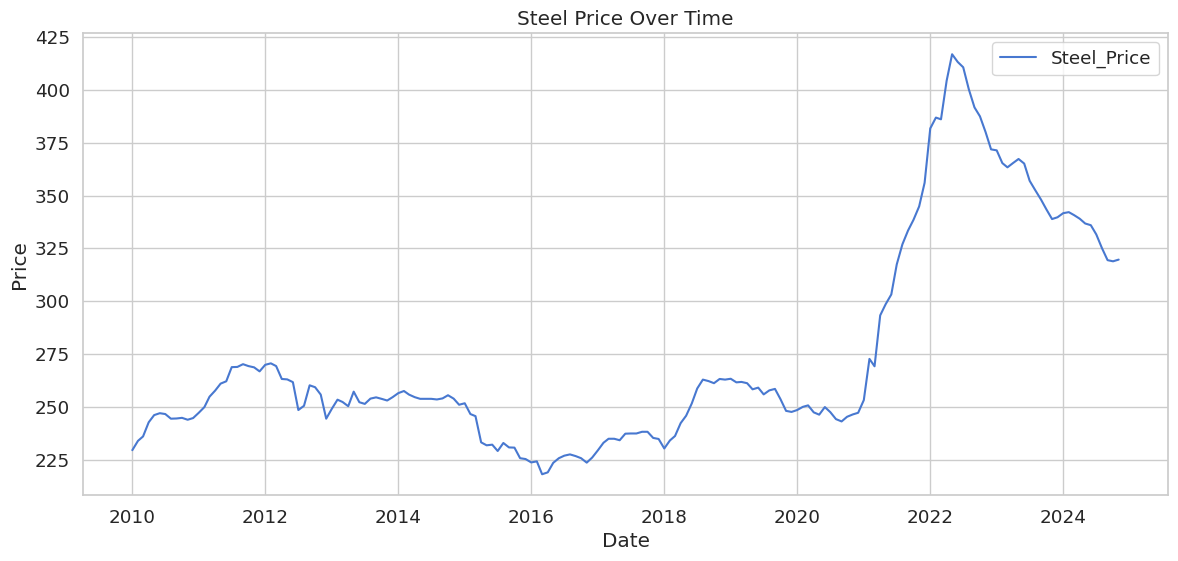

In [10]:
# Plot steel price
plot_time_series(data[['Steel_Price']], 'Steel Price Over Time', 'Price')

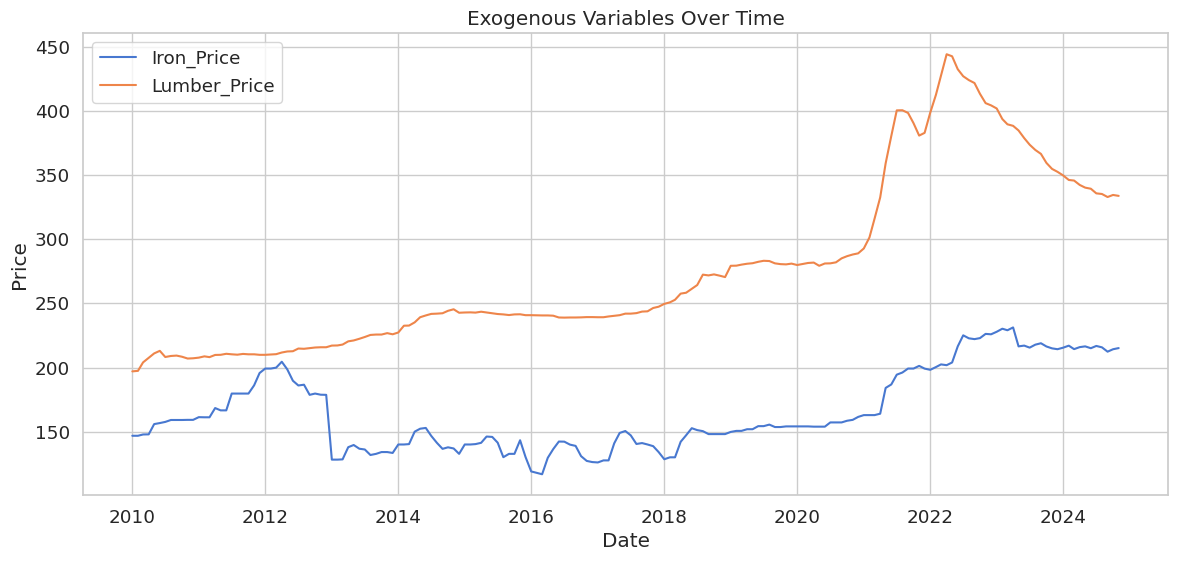

In [11]:
# Plot exogenous variables
plot_time_series(data[['Iron_Price', 'Lumber_Price']], 'Exogenous Variables Over Time', 'Price')

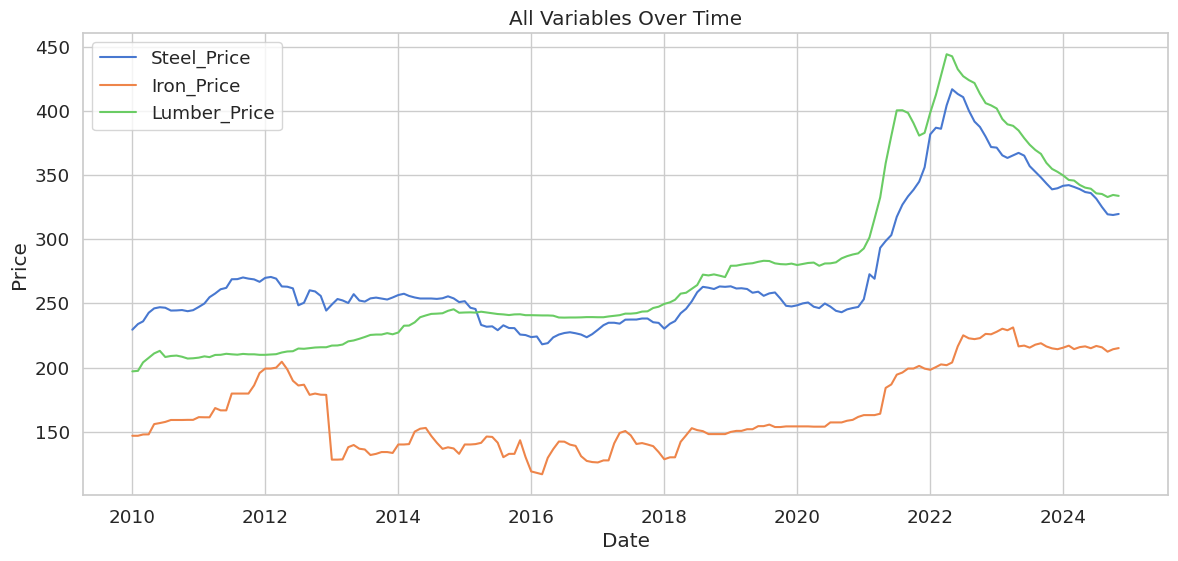

In [12]:
# Plot all variables
plot_time_series(data[['Steel_Price', 'Iron_Price', 'Lumber_Price']], 'All Variables Over Time', 'Price')

# Prepare the Data

In [13]:
def create_lag_features(data, target_col, exog_cols, lags=3):
    """
    Create lag features for target and exogenous variables.

    Parameters:
    - data: DataFrame containing all data.
    - target_col: Name of the target column.
    - exog_cols: List of exogenous variable column names.
    - lags: Number of lag periods.

    Returns:
    - data_with_lags: DataFrame with lag features.
    """
    data_with_lags = data.copy()
    for lag in range(1, lags + 1):
        data_with_lags[f'{target_col}_Lag{lag}'] = data_with_lags[target_col].shift(lag)
        for exog in exog_cols:
            data_with_lags[f'{exog}_Lag{lag}'] = data_with_lags[exog].shift(lag)
    data_with_lags.dropna(inplace=True)  # Drop rows with NaN values due to lagging
    return data_with_lags

In [14]:
# Create lag features for ANN
lags = 3
data_with_lags = create_lag_features(data, 'Steel_Price', ['Iron_Price', 'Lumber_Price'], lags)
display(data_with_lags.head())
print(f"\nDataset shape after creating lag features: {data_with_lags.shape}")

,Steel_Price,Iron_Price,Lumber_Price,Steel_Price_Lag1,Iron_Price_Lag1,Lumber_Price_Lag1,Steel_Price_Lag2,Iron_Price_Lag2,Lumber_Price_Lag2,Steel_Price_Lag3,Iron_Price_Lag3,Lumber_Price_Lag3
Date,,,,,,,,,,,,
2010-04-01,242.7,147.9,207.6,236.0,147.8,204.0,233.9,146.8,197.4,229.5,146.8,197.0
2010-05-01,246.1,155.9,211.0,242.7,147.9,207.6,236.0,147.8,204.0,233.9,146.8,197.4
2010-06-01,247.0,156.7,213.0,246.1,155.9,211.0,242.7,147.9,207.6,236.0,147.8,204.0
2010-07-01,246.6,157.6,208.2,247.0,156.7,213.0,246.1,155.9,211.0,242.7,147.9,207.6
2010-08-01,244.4,159.1,209.0,246.6,157.6,208.2,247.0,156.7,213.0,246.1,155.9,211.0



Dataset shape after creating lag features: (176, 12)


In [15]:
def train_test_split_custom(original_data, data_with_lags, test_size=0.2):
    """
    Split both original and lagged data into training and testing sets.

    Parameters:
    - original_data: DataFrame without lag features for Auto ARIMA.
    - data_with_lags: DataFrame with lag features for ANN.
    - test_size: Proportion of the dataset to include in the test split.

    Returns:
    - train_arima: Training set for Auto ARIMA.
    - test_arima: Testing set for Auto ARIMA.
    - train_ann: Training set for ANN with lag features.
    - test_ann: Testing set for ANN with lag features.
    """
    split_point_original = int(len(original_data) * (1 - test_size))
    train_arima = original_data.iloc[:split_point_original]
    test_arima = original_data.iloc[split_point_original:]

    split_point_lagged = int(len(data_with_lags) * (1 - test_size))
    train_ann = data_with_lags.iloc[:split_point_lagged]
    test_ann = data_with_lags.iloc[split_point_lagged:]

    return train_arima, test_arima, train_ann, test_ann

In [16]:
# Perform train-test split
train_arima, test_arima, train_ann, test_ann = train_test_split_custom(data, data_with_lags, test_size=0.2)

# Print shapes
print(f"Auto ARIMA - Training set shape: {train_arima.shape}")
print(f"Auto ARIMA - Testing set shape: {test_arima.shape}")
print(f"ANN - Training set shape: {train_ann.shape}")
print(f"ANN - Testing set shape: {test_ann.shape}")

Auto ARIMA - Training set shape: (143, 3)
Auto ARIMA - Testing set shape: (36, 3)
ANN - Training set shape: (140, 12)
ANN - Testing set shape: (36, 12)


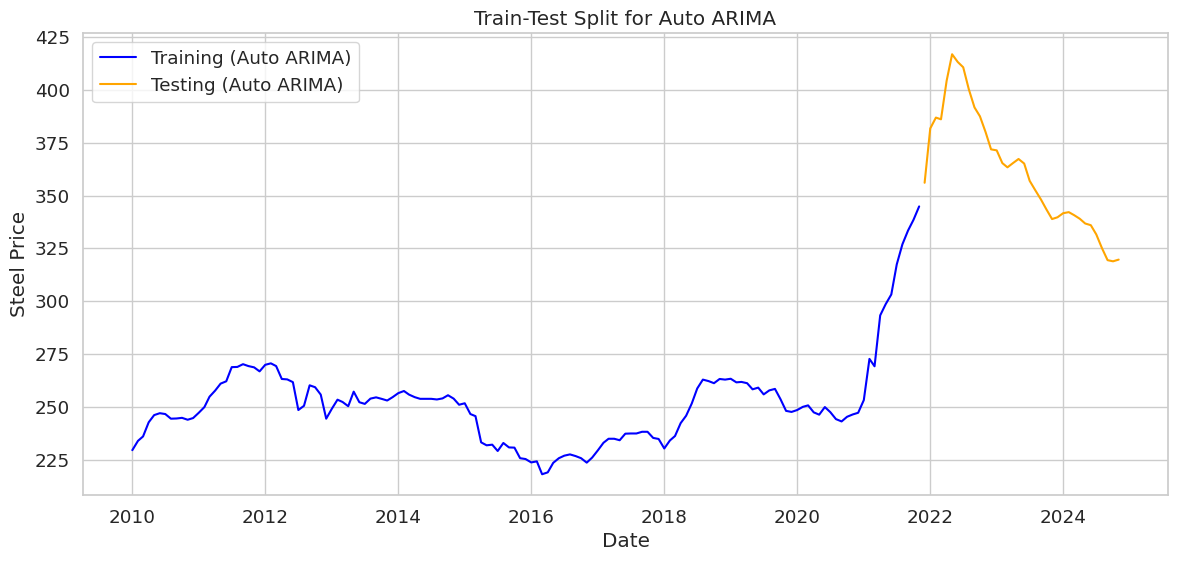

In [17]:
# Visualize the splits for Auto ARIMA
plt.figure(figsize=(14, 6))
plt.plot(train_arima.index, train_arima['Steel_Price'], label='Training (Auto ARIMA)', color='blue')
plt.plot(test_arima.index, test_arima['Steel_Price'], label='Testing (Auto ARIMA)', color='orange')
plt.title('Train-Test Split for Auto ARIMA')
plt.xlabel('Date')
plt.ylabel('Steel Price')
plt.legend()
plt.show()

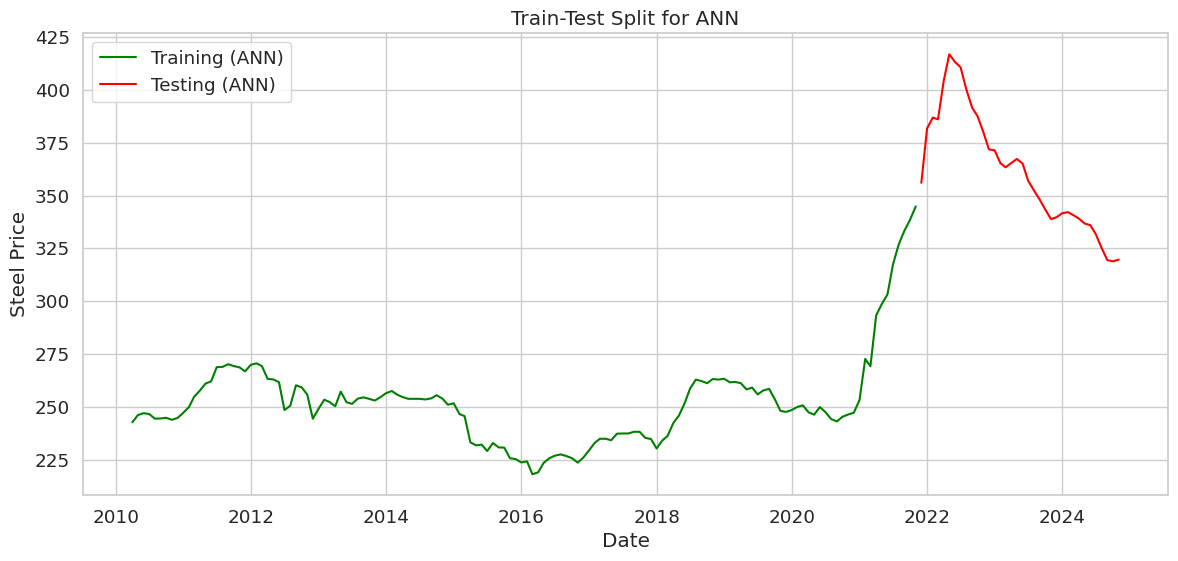

In [18]:
# Visualize the splits for ANN
plt.figure(figsize=(14, 6))
plt.plot(train_ann.index, train_ann['Steel_Price'], label='Training (ANN)', color='green')
plt.plot(test_ann.index, test_ann['Steel_Price'], label='Testing (ANN)', color='red')
plt.title('Train-Test Split for ANN')
plt.xlabel('Date')
plt.ylabel('Steel Price')
plt.legend()
plt.show()

In [19]:
def prepare_ann_data(train, test, target_col, ann_exog_cols, lags=3):
    """
    Prepare data for ANN model with lag features.

    Parameters:
    - train: Training set DataFrame with lag features.
    - test: Testing set DataFrame with lag features.
    - target_col: Name of the target column.
    - ann_exog_cols: List of exogenous variable column names.
    - lags: Number of lag periods.

    Returns:
    - X_train_tensor: Training features as torch tensors.
    - y_train_tensor: Training target as torch tensors.
    - X_test_tensor: Testing features as torch tensors.
    - y_test_tensor: Testing target as torch tensors.
    - scaler: Fitted StandardScaler object.
    - feature_cols: List of feature column names used for ANN.
    """
    # Define feature columns: current exog variables + lagged features
    feature_cols = ann_exog_cols.copy()
    for lag in range(1, lags + 1):
        feature_cols.append(f'{target_col}_Lag{lag}')
        for exog in ann_exog_cols:
            feature_cols.append(f'{exog}_Lag{lag}')

    X_train = train[feature_cols].values
    y_train = train[target_col].values
    X_test = test[feature_cols].values
    y_test = test[target_col].values

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert to torch tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, scaler, feature_cols

In [20]:
# Prepare data for ANN model
X_train_ann, y_train_ann, X_test_ann, y_test_ann, scaler_ann, feature_cols_ann = prepare_ann_data(
    train_ann, test_ann, 'Steel_Price', ['Iron_Price', 'Lumber_Price'], lags=lags
)

# Print shapes
print(f"ANN - X_train shape: {X_train_ann.shape}")
print(f"ANN - y_train shape: {y_train_ann.shape}")
print(f"ANN - X_test shape: {X_test_ann.shape}")
print(f"ANN - y_test shape: {y_test_ann.shape}")

ANN - X_train shape: torch.Size([140, 11])
ANN - y_train shape: torch.Size([140, 1])
ANN - X_test shape: torch.Size([36, 11])
ANN - y_test shape: torch.Size([36, 1])


# Train the Models

In [21]:
def fit_arima_tf_auto(train, target_col, exog_cols, seasonal=True, m=12, stepwise=True):
    """
    Fit a Transfer Function ARIMA model using auto_arima for order selection.

    Parameters:
    - train: Training set DataFrame.
    - target_col: Name of the target column.
    - exog_cols: List of exogenous variable column names.
    - seasonal: Boolean indicating if seasonal ARIMA should be considered.
    - m: Seasonal period for seasonal ARIMA.
    - stepwise: Boolean indicating if stepwise selection should be used.

    Returns:
    - model: Fitted auto_arima model.
    """
    exog_train = train[exog_cols]
    model = auto_arima(
        train[target_col],
        exogenous=exog_train,
        seasonal=seasonal,
        m=m,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=stepwise
    )
    return model

In [22]:
# Fit Auto ARIMA model
arima_model = fit_arima_tf_auto(
    train_arima, 'Steel_Price', ['Iron_Price', 'Lumber_Price'], seasonal=True, m=12
)

print(f"\nAuto ARIMA model summary:\n{arima_model.summary()}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=821.272, Time=5.51 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=834.150, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=830.843, Time=0.42 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=833.057, Time=1.50 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=836.706, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=819.286, Time=5.79 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=817.305, Time=0.33 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=819.284, Time=2.78 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=816.034, Time=0.12 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=818.002, Time=0.86 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=818.005, Time=0.24 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=819.991, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=828.060, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=816.895, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[12] intercep

In [23]:
class ANNModel(nn.Module):
    def __init__(self, input_size, hidden_sizes=[64, 32], dropout=0.1):
        """
        Initialize the ANN model.

        Parameters:
        - input_size (int): Number of input features.
        - hidden_sizes (list): List containing the number of neurons in each hidden layer.
        - dropout (float): Dropout rate to prevent overfitting.
        """
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.output = nn.Linear(hidden_sizes[1], 1)

    def forward(self, x):
        """
        Forward pass of the ANN model.

        Parameters:
        - x (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Output tensor.
        """
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.output(out)
        return out

In [24]:
def train_ann_model(
    model,
    X_train,
    y_train,
    epochs=1000,
    batch_size=32,
    optimizer='adamw',
    learning_rate=0.001,
    print_every=100,
    checkpoint_path='best_ann_model.pth',
    val_split=0.1,
    patience=10,
    factor=0.1,
    scheduler_patience=10
):
    """
    Train the ANN model with validation and early stopping.

    Parameters:
    - model: ANNModel instance.
    - X_train: Training features as torch tensors.
    - y_train: Training target as torch tensors.
    - epochs: Number of training epochs.
    - batch_size: Size of each training batch.
    - optimizer: Type of optimizer to use.
    - learning_rate: Initial learning rate for the optimizer.
    - print_every: Frequency of printing loss.
    - checkpoint_path: File path to save the best model.
    - val_split: Fraction of training data to use as validation.
    - patience: Number of epochs with no improvement after which training will be stopped.
    - factor: Factor by which the learning rate will be reduced. new_lr = lr * factor.
    - scheduler_patience: Number of epochs with no improvement after which the learning rate will be reduced.

    Returns:
    - model: Trained ANN model.
    """
    criterion = nn.MSELoss()

    if optimizer.lower() == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    elif optimizer.lower() == 'adahessian':
        optimizer = torch_optim.Adahessian(model.parameters(), lr=learning_rate, weight_decay=0.01, hessian_power=1.0)

    # Split into training and validation sets
    total_samples = X_train.size(0)
    val_size = int(total_samples * val_split)
    train_size = total_samples - val_size

    X_train_data = X_train[:train_size]
    y_train_data = y_train[:train_size]
    X_val = X_train[train_size:]
    y_val = y_train[train_size:]

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_data, y_train_data)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Define the learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=factor,
        patience=scheduler_patience
    )

    best_val_loss = np.inf
    epochs_no_improve = 0

    for epoch in range(1, epochs + 1):
        # Training phase
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward(create_graph=True)
            optimizer.step()
            train_loss += loss.item() * batch_X.size(0)
        train_loss /= train_size

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item() * batch_X.size(0)
        val_loss /= val_size

        # Store old LR before scheduler step
        old_lr = optimizer.param_groups[0]['lr']

        # Step the scheduler with the validation loss
        scheduler.step(val_loss)

        # Check if the LR has been reduced
        new_lr = optimizer.param_groups[0]['lr']
        if new_lr < old_lr:
            print(f"Learning rate reduced from {old_lr:.1e} to {new_lr:.1e}")

        # Check for improvement and save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), checkpoint_path)
        else:
            epochs_no_improve += 1

        # Early stopping
        if epochs_no_improve >= patience:
            print(f"Early stopping at Epoch {epoch}")
            break

        # Print training, validation loss and current LR
        if epoch % print_every == 0 or epoch == 1:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Learning Rate: {current_lr:.1e}")

    # Load the best model weights
    if os.path.exists(checkpoint_path):
        model.load_state_dict(torch.load(checkpoint_path))
        print(f"Loaded best model with validation loss: {best_val_loss:.4f}")
    else:
        print("No checkpoint found. Using the current model weights.")

    return model

In [25]:
# Set model parameters
dropout_rate = 0.01
hidden_layers = [64, 32]
learning_rate = 0.001
optimizer = 'adamw'
batch_size = 32
epochs = 50000
print_every = 1000
checkpoint_path = 'best_ann_model.pth'
val_split = 0.1
patience = 10000
factor = 0.1
scheduler_patience = 5000

In [26]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    return seed

In [27]:
# Set the seed
set_seed()

# Initialize ANN model
input_size_ann = X_train_ann.shape[1]
ann_model = ANNModel(
    input_size=input_size_ann,
    hidden_sizes=hidden_layers,
    dropout=dropout_rate
)

print("Training ANN model:")
ann_model = train_ann_model(
    model=ann_model,
    X_train=X_train_ann,
    y_train=y_train_ann,
    epochs=epochs,
    batch_size=batch_size,
    optimizer=optimizer,
    learning_rate=learning_rate,
    print_every=print_every,
    checkpoint_path=checkpoint_path,
    val_split=val_split,
    patience=patience,
    factor=factor,
    scheduler_patience=scheduler_patience
)

Training ANN model:
Epoch 1/50000, Training Loss: 61531.1812, Validation Loss: 86492.3281, Learning Rate: 1.0e-03
Epoch 1000/50000, Training Loss: 63.2813, Validation Loss: 26279.7344, Learning Rate: 1.0e-03
Epoch 2000/50000, Training Loss: 45.9431, Validation Loss: 10596.6738, Learning Rate: 1.0e-03
Epoch 3000/50000, Training Loss: 47.5324, Validation Loss: 5251.0947, Learning Rate: 1.0e-03
Epoch 4000/50000, Training Loss: 58.6428, Validation Loss: 2813.8401, Learning Rate: 1.0e-03
Epoch 5000/50000, Training Loss: 53.2370, Validation Loss: 1393.0042, Learning Rate: 1.0e-03
Epoch 6000/50000, Training Loss: 40.9085, Validation Loss: 771.3188, Learning Rate: 1.0e-03
Epoch 7000/50000, Training Loss: 39.2398, Validation Loss: 325.9131, Learning Rate: 1.0e-03
Epoch 8000/50000, Training Loss: 44.4505, Validation Loss: 372.9580, Learning Rate: 1.0e-03
Epoch 9000/50000, Training Loss: 62.3224, Validation Loss: 199.2169, Learning Rate: 1.0e-03
Epoch 10000/50000, Training Loss: 39.9035, Validati

# Get Forecasts

In [28]:
def forecast_arima_auto(model, test, exog_cols):
    """
    Generate forecasts using the fitted Auto ARIMA model.

    Parameters:
    - model: Fitted auto_arima model.
    - test: Testing set DataFrame.
    - exog_cols: List of exogenous variable column names.

    Returns:
    - forecast: Series containing Auto ARIMA forecasts.
    """
    exog_test = test[exog_cols]
    forecast = model.predict(n_periods=len(test), exogenous=exog_test)
    forecast = pd.Series(forecast, index=test.index)
    return forecast

In [29]:
# Get Auto ARIMA forecast
forecast_arima = forecast_arima_auto(arima_model, test_arima, ['Iron_Price', 'Lumber_Price'])
print(f"Forecast length (Auto ARIMA): {len(forecast_arima)}")

Forecast length (Auto ARIMA): 36


In [30]:
def forecast_ann(model, X_test):
    """
    Generate forecasts using the trained ANN model.

    Parameters:
    - model: Trained ANN model.
    - X_test: Testing features as torch tensors.

    Returns:
    - forecast: Numpy array containing ANN forecasts.
    """
    model.eval()
    with torch.no_grad():
        forecast = model(X_test).numpy().flatten()
    return forecast

In [31]:
# Get ANN forecast
forecast_ann = forecast_ann(ann_model, X_test_ann)
print(f"Forecast length (ANN): {len(forecast_ann)}")

Forecast length (ANN): 36


# Optimize Weights

In [32]:
class WeightsOptimizer:
    """
    Class to optimize weights for the combination forecasts using various optimization libraries.
    Supports: SciPy, CVXPY, and Mystic.
    """
    def __init__(self, library='scipy', **kwargs):
        """
        Initialize the WeightsOptimizer.

        Parameters:
        - library: str, one of ['scipy', 'cvxpy', 'mystic']. Default is 'scipy'.
        - kwargs: Additional arguments for the selected optimization solver.
        """
        self.library = library.lower()
        self.solver_args = kwargs

    def mape_loss(self, weights, forecast_arima, forecast_ann, actual):
        """
        Objective function: Mean Absolute Percentage Error (MAPE).
        """
        combined_forecast = weights[0] * forecast_arima + weights[1] * forecast_ann
        # Avoid division by zero
        mask = actual != 0
        mape = np.mean(np.abs((actual[mask] - combined_forecast[mask]) / actual[mask])) * 100
        return mape

    def optimize(self, forecast_arima, forecast_ann, actual):
        """
        Perform weights optimization using the specified method.

        Parameters:
        - forecast_arima: Array-like, Auto ARIMA forecasts.
        - forecast_ann: Array-like, ANN forecasts.
        - actual: Array-like, actual target values.

        Returns:
        - optimized_weights: Optimized weights as a numpy array [w_arima, w_ann].
        """
        if self.library == 'scipy':
            return self._optimize_scipy(forecast_arima, forecast_ann, actual)
        elif self.library == 'cvxpy':
            return self._optimize_cvxpy(forecast_arima, forecast_ann, actual)
        elif self.library == 'mystic':
            return self._optimize_mystic(forecast_arima, forecast_ann, actual)
        else:
            raise ValueError(f"Unsupported optimization library: {self.library}")

    def _optimize_scipy(self, forecast_arima, forecast_ann, actual):
        """
        Weights optimization using SciPy.
        """
        initial_weights = [0.5, 0.5]
        bounds = Bounds([0, 0], [1, 1])
        linear_constraint = LinearConstraint([1, 1], 1, 1)

        result = minimize(
            self.mape_loss,
            initial_weights,
            args=(forecast_arima, forecast_ann, actual),
            method=self.solver_args.get('method', 'SLSQP'),
            bounds=bounds,
            constraints=[linear_constraint]
        )

        if not result.success:
            raise ValueError(f"SciPy optimization failed: {result.message}")

        return result.x

    def _optimize_cvxpy(self, forecast_arima, forecast_ann, actual):
        """
        Weights optimization using CVXPY.
        """
        w = cp.Variable(2, nonneg=True)
        combined_forecast = w[0] * forecast_arima + w[1] * forecast_ann
        # Avoid division by zero
        mask = actual != 0
        mape = cp.sum(cp.abs((actual[mask] - combined_forecast[mask]) / actual[mask])) / len(actual[mask]) * 100

        constraints = [
            w[0] + w[1] == 1  # Weights sum to 1
        ]

        problem = cp.Problem(cp.Minimize(mape), constraints)
        problem.solve(solver=self.solver_args.get('solver', cp.SCS))

        if problem.status not in ["optimal", "optimal_inaccurate"]:
            raise ValueError(f"CVXPY optimization failed: {problem.status}")

        return w.value

    def _optimize_mystic(self, forecast_arima, forecast_ann, actual):
        """
        Weights optimization using Mystic.
        """
        def mape_loss(weights):
            return self.mape_loss(weights, forecast_arima, forecast_ann, actual)

        def constraint(weights):
            # Enforce weights to be between 0 and 1 and sum to 1
            weights = np.clip(weights, 0, 1)
            weights[1] = 1 - weights[0]
            return weights

        constraint_solver = as_constraint(constraint)
        initial_weights = [0.5, 0.5]

        result = fmin(mape_loss, initial_weights, constraints=constraint_solver, disp=False)

        return result

In [33]:
# Optimize component model weights using SciPy
optimizer = WeightsOptimizer(library='scipy', method='SLSQP')
optimized_weights = optimizer.optimize(
    forecast_arima.values, forecast_ann, test_arima['Steel_Price'].values
)

print(f"Optimized Weights: Auto ARIMA = {optimized_weights[0]:.4f}, ANN = {optimized_weights[1]:.4f}")

Optimized Weights: Auto ARIMA = 0.2526, ANN = 0.7474


In [34]:
# Optimize component model weights using CVXPY
optimizer_2 = WeightsOptimizer(library='cvxpy')
optimized_weights_2 = optimizer_2.optimize(
    forecast_arima.values, forecast_ann, test_arima['Steel_Price'].values
)

print(f"Optimized Weights: Auto ARIMA = {optimized_weights_2[0]:.4f}, ANN = {optimized_weights_2[1]:.4f}")

Optimized Weights: Auto ARIMA = 0.2661, ANN = 0.7339


In [35]:
# Optimize component model weights using Mystic
optimizer_3 = WeightsOptimizer(library='mystic')
optimized_weights_3 = optimizer_3.optimize(
    forecast_arima.values, forecast_ann, test_arima['Steel_Price'].values
)

print(f"Optimized Weights: Auto ARIMA = {optimized_weights_3[0]:.4f}, ANN = {optimized_weights_3[1]:.4f}")

Optimized Weights: Auto ARIMA = 0.2660, ANN = 0.7340


# Evaluate Results

In [36]:
# Combined forecasts
combined_forecast_1 = optimized_weights[0] * forecast_arima + optimized_weights[1] * forecast_ann
combined_forecast_2 = optimized_weights_2[0] * forecast_arima + optimized_weights_2[1] * forecast_ann
combined_forecast_3 = optimized_weights_3[0] * forecast_arima + optimized_weights_3[1] * forecast_ann
print(f"Combined forecast length: {len(combined_forecast_1)}")

Combined forecast length: 36


In [37]:
def evaluate_forecasts(actual, forecast, forecast_name='Forecast'):
    """
    Calculate and print evaluation metrics for forecasts.

    Parameters:
    - actual: Array-like, actual target values.
    - forecast: Array-like, forecasted values.
    - forecast_name: Name of the forecast model.
    """
    # Avoid division by zero
    mask = actual != 0
    mape = np.mean(np.abs((actual[mask] - forecast[mask]) / actual[mask])) * 100
    mae = mean_absolute_error(actual, forecast)
    mse = mean_squared_error(actual, forecast)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, forecast)

    print(f'--- {forecast_name} Metrics ---')
    print(f'MAPE: {mape:.2f}%')
    print(f'MAE: {mae:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'R² Score: {r2:.4f}\n')

In [38]:
# Evaluate forecasts
evaluate_forecasts(test_arima['Steel_Price'].values, forecast_arima.values, 'Auto ARIMA')
evaluate_forecasts(test_ann['Steel_Price'].values, forecast_ann, 'ANN')
evaluate_forecasts(test_arima['Steel_Price'].values, combined_forecast_1, 'Combined Forecast 1')
evaluate_forecasts(test_arima['Steel_Price'].values, combined_forecast_2, 'Combined Forecast 2')
evaluate_forecasts(test_arima['Steel_Price'].values, combined_forecast_3, 'Combined Forecast 3')

--- Auto ARIMA Metrics ---
MAPE: 9.58%
MAE: 33.71
RMSE: 38.15
R² Score: -0.9033

--- ANN Metrics ---
MAPE: 3.69%
MAE: 13.21
RMSE: 15.04
R² Score: 0.7039

--- Combined Forecast 1 Metrics ---
MAPE: 1.36%
MAE: 5.05
RMSE: 6.48
R² Score: 0.9451

--- Combined Forecast 2 Metrics ---
MAPE: 1.35%
MAE: 4.99
RMSE: 6.45
R² Score: 0.9457

--- Combined Forecast 3 Metrics ---
MAPE: 1.35%
MAE: 4.99
RMSE: 6.45
R² Score: 0.9457



In [39]:
def plot_forecasts(test, forecast_arima, forecast_ann, combined_forecast):
    """
    Plot actual and forecasted steel prices.

    Parameters:
    - test: Testing set DataFrame.
    - forecast_arima: Auto ARIMA forecast Series.
    - forecast_ann: ANN forecast array.
    - combined_forecast: Combined forecast array.
    """
    plt.figure(figsize=(14, 8))
    plt.plot(test.index, test['Steel_Price'], label='Actual', color='black')
    plt.plot(test.index, forecast_arima, label='Auto ARIMA', color='red')
    plt.plot(test.index, forecast_ann, label='ANN', color='orange')
    plt.plot(test.index, combined_forecast, label='Combined Forecast', color='green', linestyle='--')
    plt.title('Steel Price Forecasting')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

Combined Forecast 1:


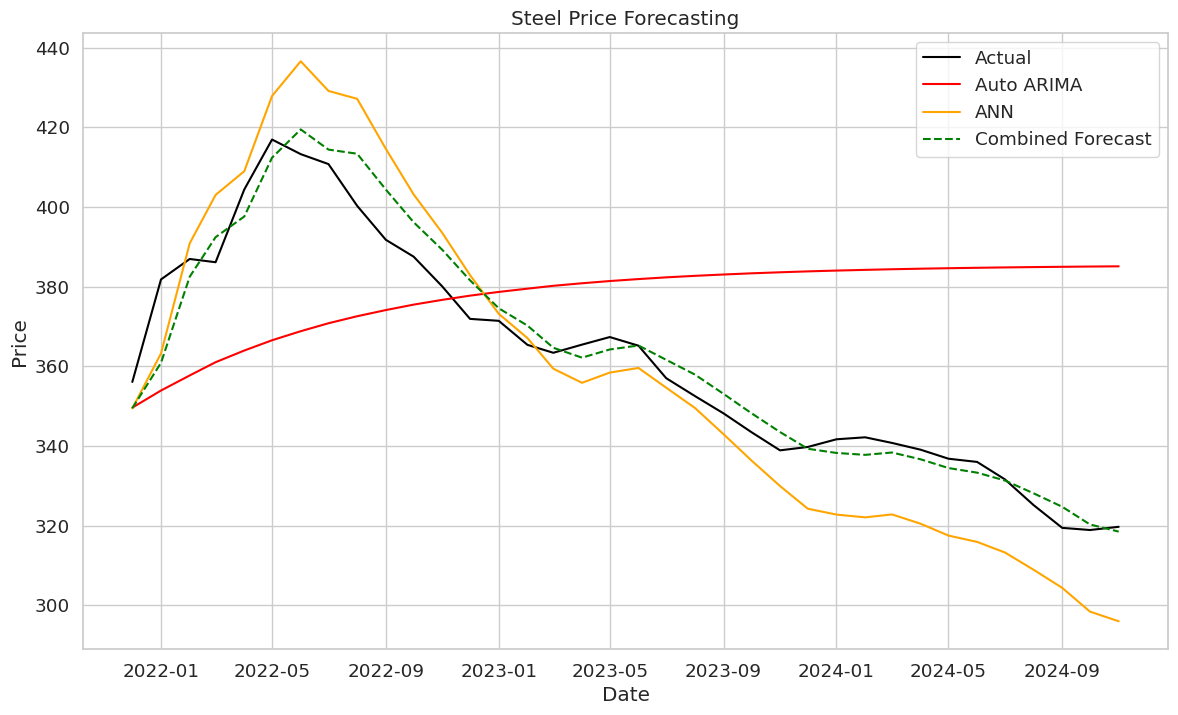


Combined Forecast 2:


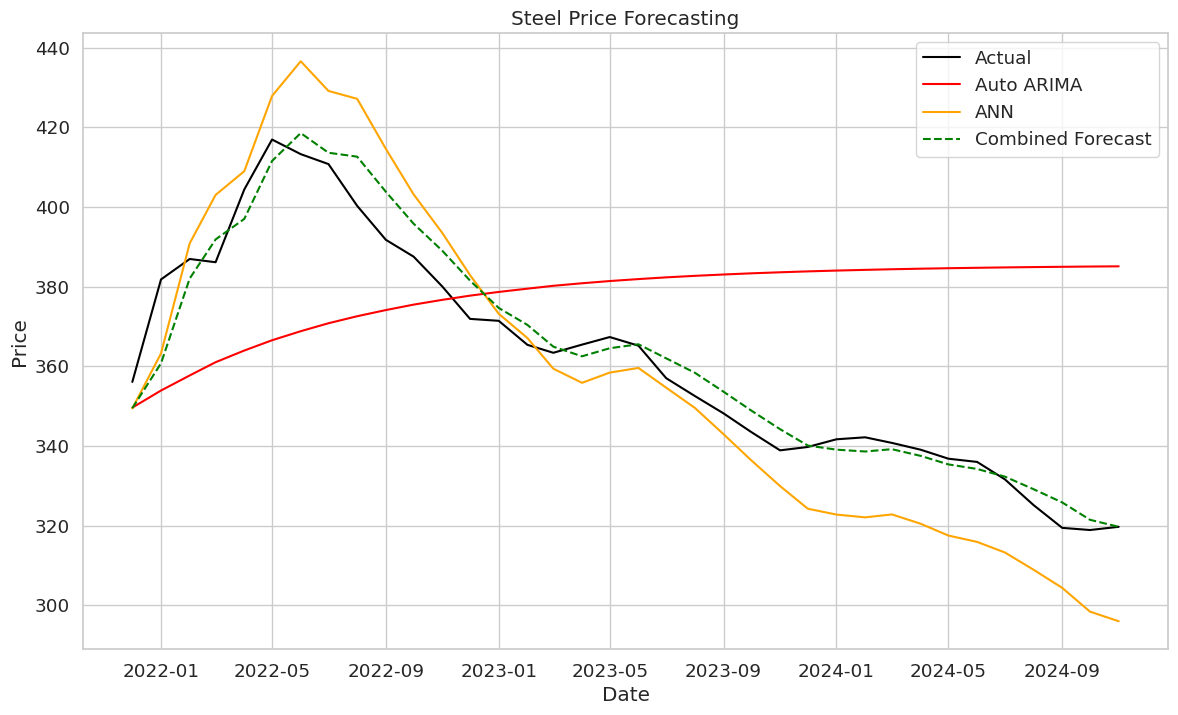


Combined Forecast 3:


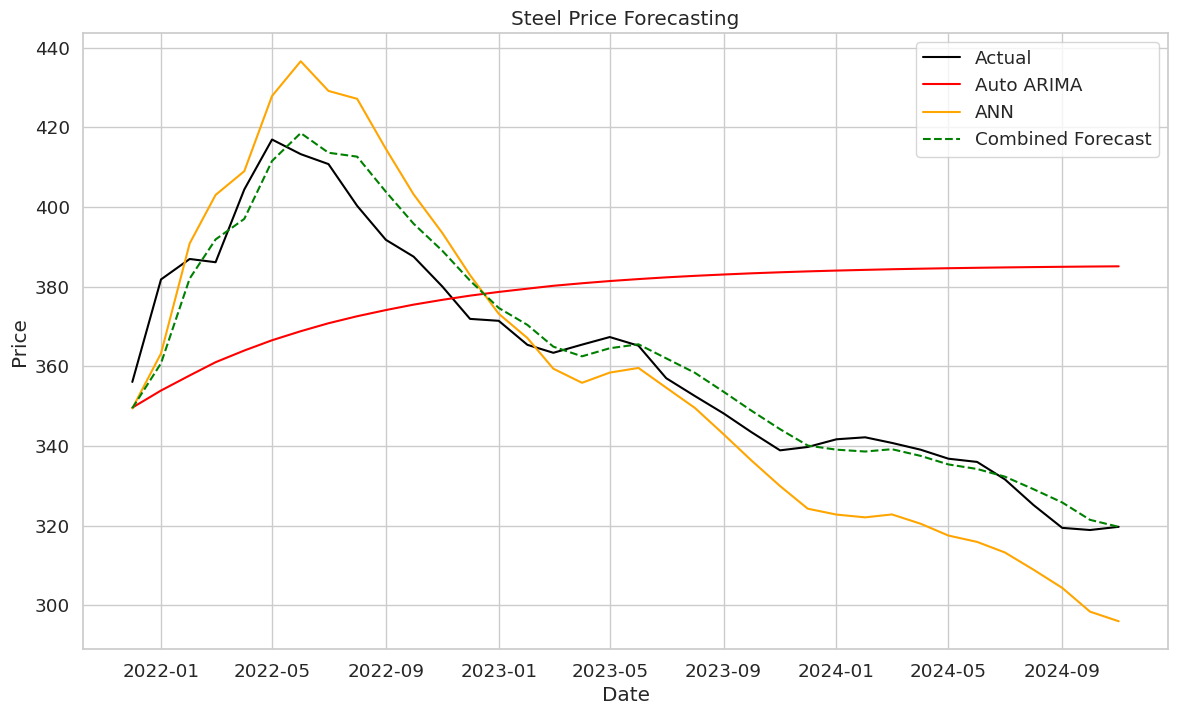

In [40]:
# Plot all forecasts
print("Combined Forecast 1:")
plot_forecasts(test_arima, forecast_arima, forecast_ann, combined_forecast_1)

print("\nCombined Forecast 2:")
plot_forecasts(test_arima, forecast_arima, forecast_ann, combined_forecast_2)

print("\nCombined Forecast 3:")
plot_forecasts(test_arima, forecast_arima, forecast_ann, combined_forecast_3)

In [41]:
def plot_residuals(test, combined_forecast):
    """
    Plot residuals and their distribution.

    Parameters:
    - test: Testing set DataFrame.
    - combined_forecast: Combined forecast array.
    """
    residuals = test['Steel_Price'].values - combined_forecast

    # Plot residuals over time
    plt.figure(figsize=(14, 6))
    plt.plot(test.index, residuals, label='Residuals', color='purple')
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals of Combined Forecast')
    plt.xlabel('Date')
    plt.ylabel('Residual')
    plt.legend()
    plt.show()
    print("\n")

    # Plot error distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, bins=30, kde=True, color='green')
    plt.title('Distribution of Forecast Residuals')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.show()

Combined Forecast 1:


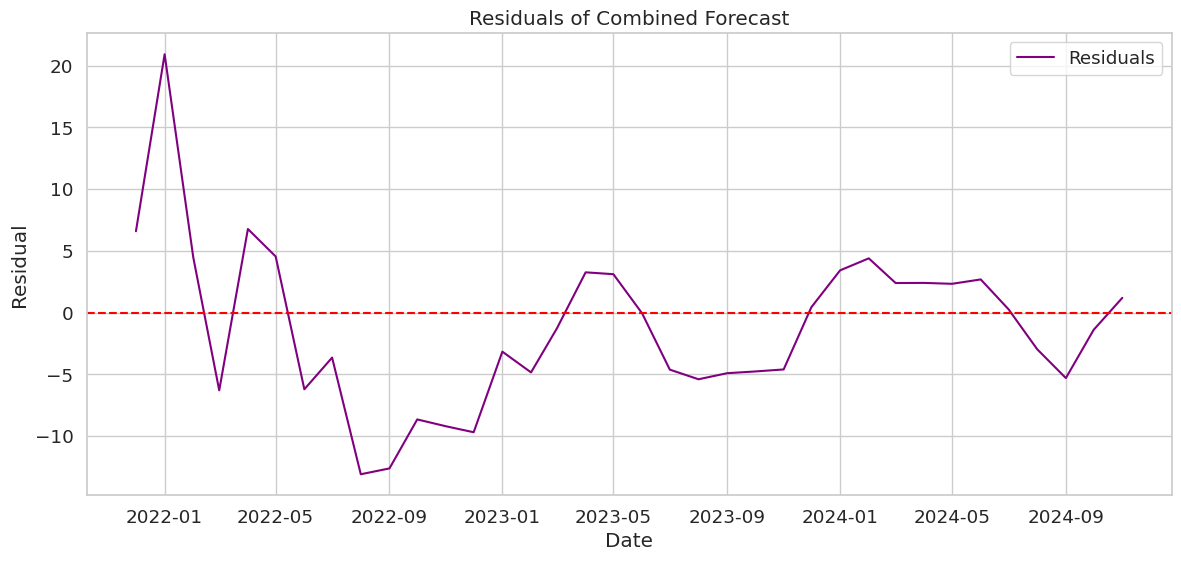

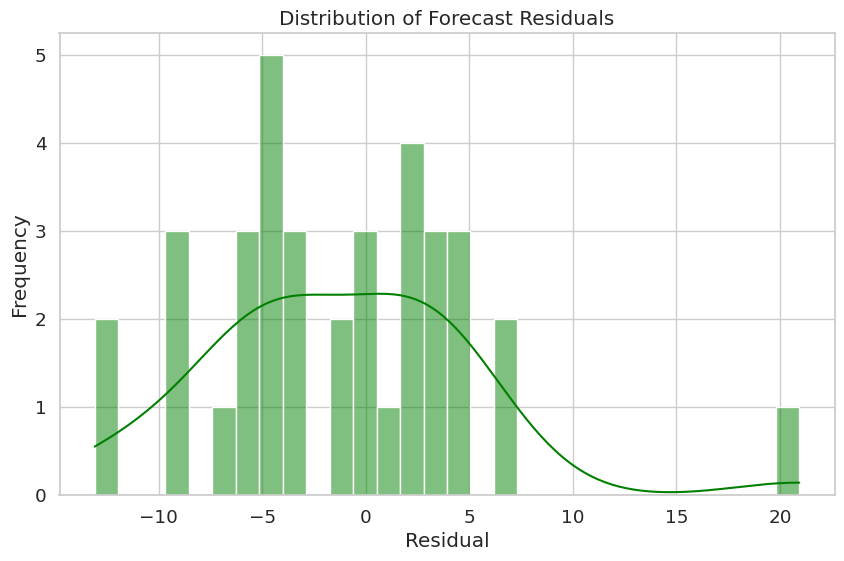


Combined Forecast 2:


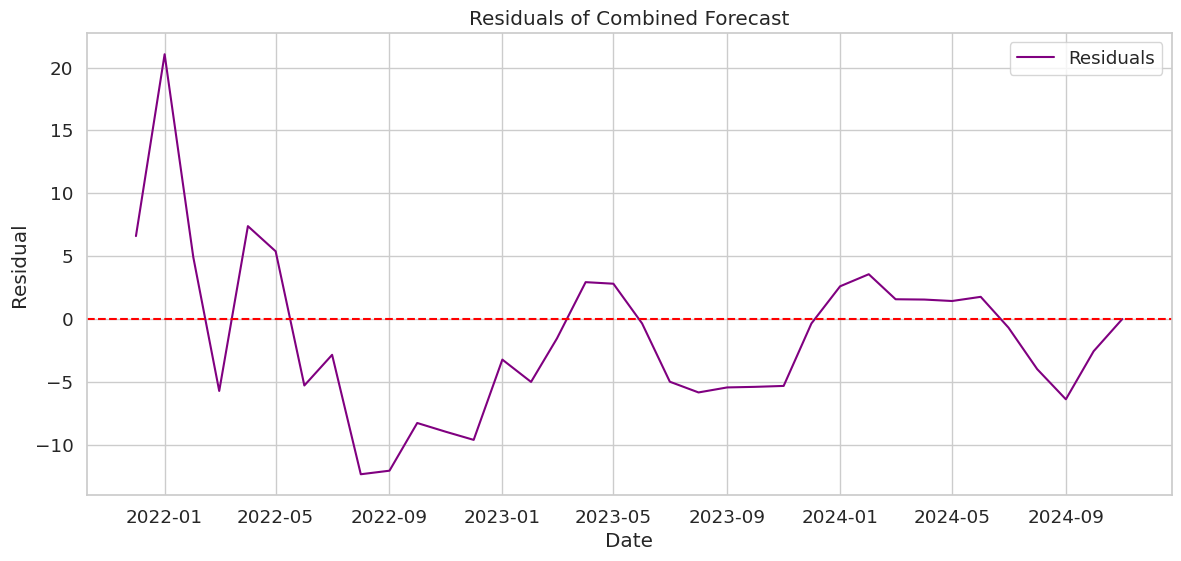

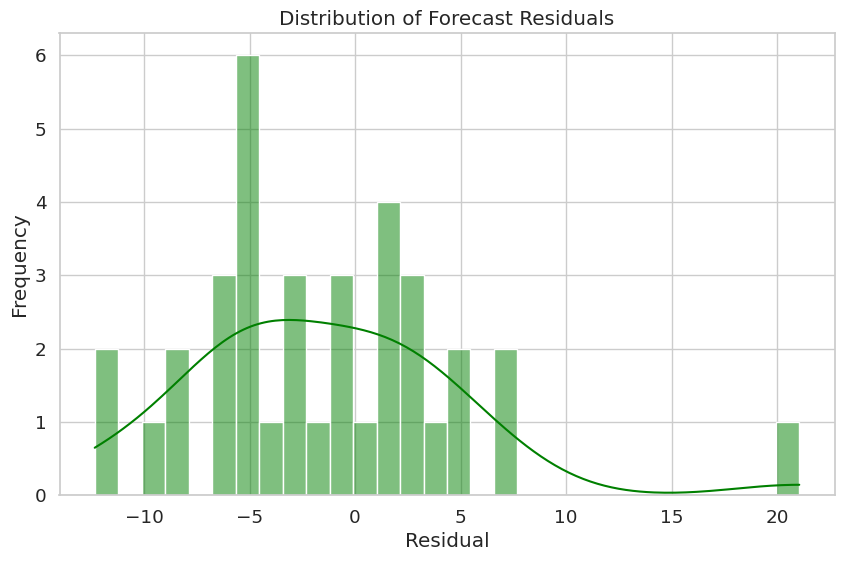


Combined Forecast 3:


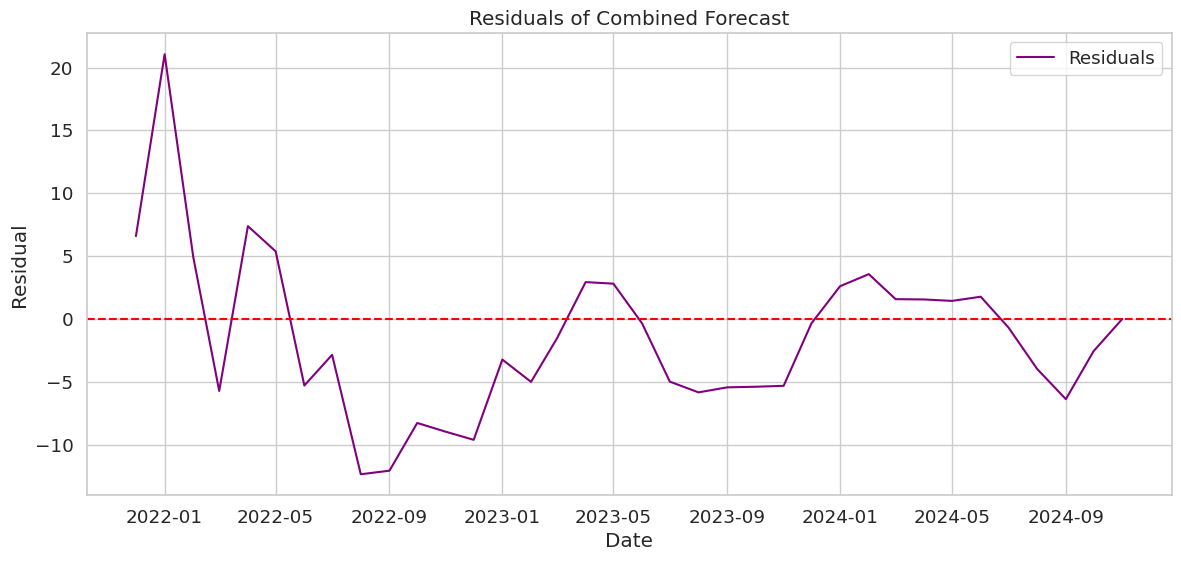

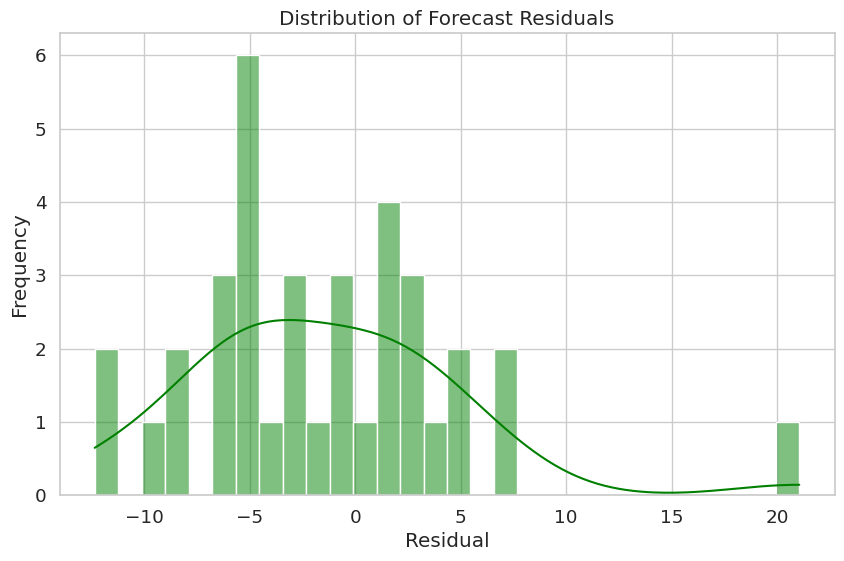

In [42]:
# Plot residuals
print("Combined Forecast 1:")
plot_residuals(test_arima, combined_forecast_1)

print("\nCombined Forecast 2:")
plot_residuals(test_arima, combined_forecast_2)

print("\nCombined Forecast 3:")
plot_residuals(test_arima, combined_forecast_3)